# MaskRCNN model testing for Fashion dataset

In [11]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [12]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#VARIABLES
NUM_CATS = 46
IMAGE_SIZE = 512
ROOT_DIR="Mask_RCNN"
model_path = 'models/mask_rcnn_fashion_0007.h5'

def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [13]:
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=ROOT_DIR
)

model.load_weights('/Users/shankar99/Documents/SSN/projects/fashionMaskRCNN/mask_rcnn_fashion_0007.h5',by_name=True)

## testing with an image

In [14]:
image_path="/Users/shankar99/Documents/SSN/projects/fashionMaskRCNN/images/004e9e21cd1aca568a8ffc77a54638ce.jpg"
image_id="004e9e21cd1aca568a8ffc77a54638ce.jpg"
result = model.detect([resize_image(image_path)])
r = result[0]
r

{'rois': array([[106, 133, 219, 188],
        [403, 194, 465, 235],
        [100, 299, 252, 355],
        [468, 255, 508, 297],
        [440, 241, 497, 274],
        [250, 338, 294, 364],
        [210, 139, 457, 327],
        [112, 144, 411, 335]], dtype=int32),
 'class_ids': array([32, 24, 32, 24, 24, 24,  7, 11], dtype=int32),
 'scores': array([0.98553896, 0.98067456, 0.97652185, 0.93389654, 0.8801466 ,
        0.8490458 , 0.8141193 , 0.76206666], dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., Fals

In [5]:
label_path='/Users/shankar99/Documents/SSN/projects/fashionMaskRCNN/label_descriptions.json'

with open(label_path) as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [6]:
label_names

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat',
 'dress',
 'jumpsuit',
 'cape',
 'glasses',
 'hat',
 'headband, head covering, hair accessory',
 'tie',
 'glove',
 'watch',
 'belt',
 'leg warmer',
 'tights, stockings',
 'sock',
 'shoe',
 'bag, wallet',
 'scarf',
 'umbrella',
 'hood',
 'collar',
 'lapel',
 'epaulette',
 'sleeve',
 'pocket',
 'neckline',
 'buckle',
 'zipper',
 'applique',
 'bead',
 'bow',
 'flower',
 'fringe',
 'ribbon',
 'rivet',
 'ruffle',
 'sequin',
 'tassel']

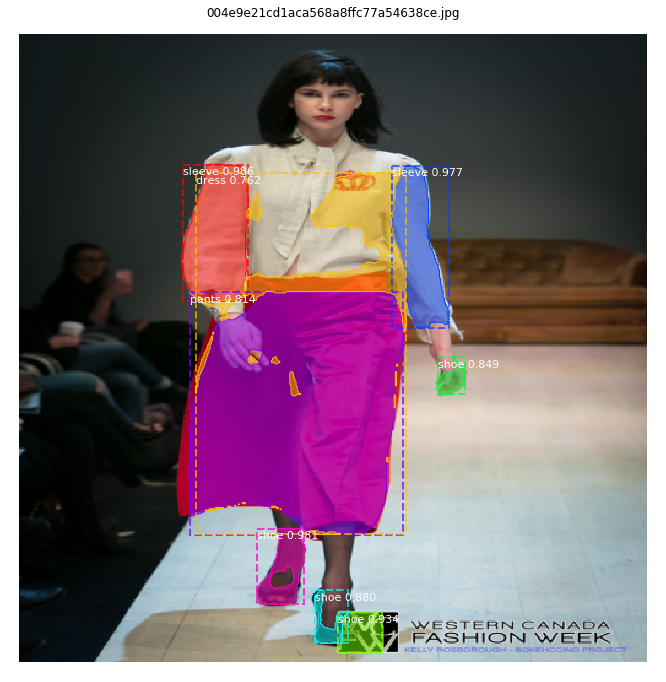

In [15]:
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois



result = model.detect([resize_image(image_path)])
r = result[0]
img = resize_image(image_path)


if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'],
                            title=image_id, figsize=(12, 12))

In [18]:
label_names[r['class_ids'][1]]

'bag, wallet'